In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LeakyReLU, Reshape, Flatten, Input,
    Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose,
    BatchNormalization
)
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.losses import BinaryCrossentropy
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kagglehub

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janvic16","key":"9b04053403de6471fc3c12a4c994e169"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub
path = kagglehub.dataset_download("soumikrakshit/anime-faces")
print("Path to dataset files:", path)

100%|██████████| 441M/441M [00:20<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


In [ ]:
BASE_DIR = "/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data"

In [ ]:
image_paths = []
for image in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image)
    image_paths.append(image_path)

print(len(image_paths))

21552


In [ ]:
image_paths[:5]

['/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/13053.png',
 '/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/9861.png',
 '/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/15877.png',
 '/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/17920.png',
 '/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/3952.png']

In [ ]:
image_paths.remove('/root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1/data/data')
print(len(image_paths))

21551


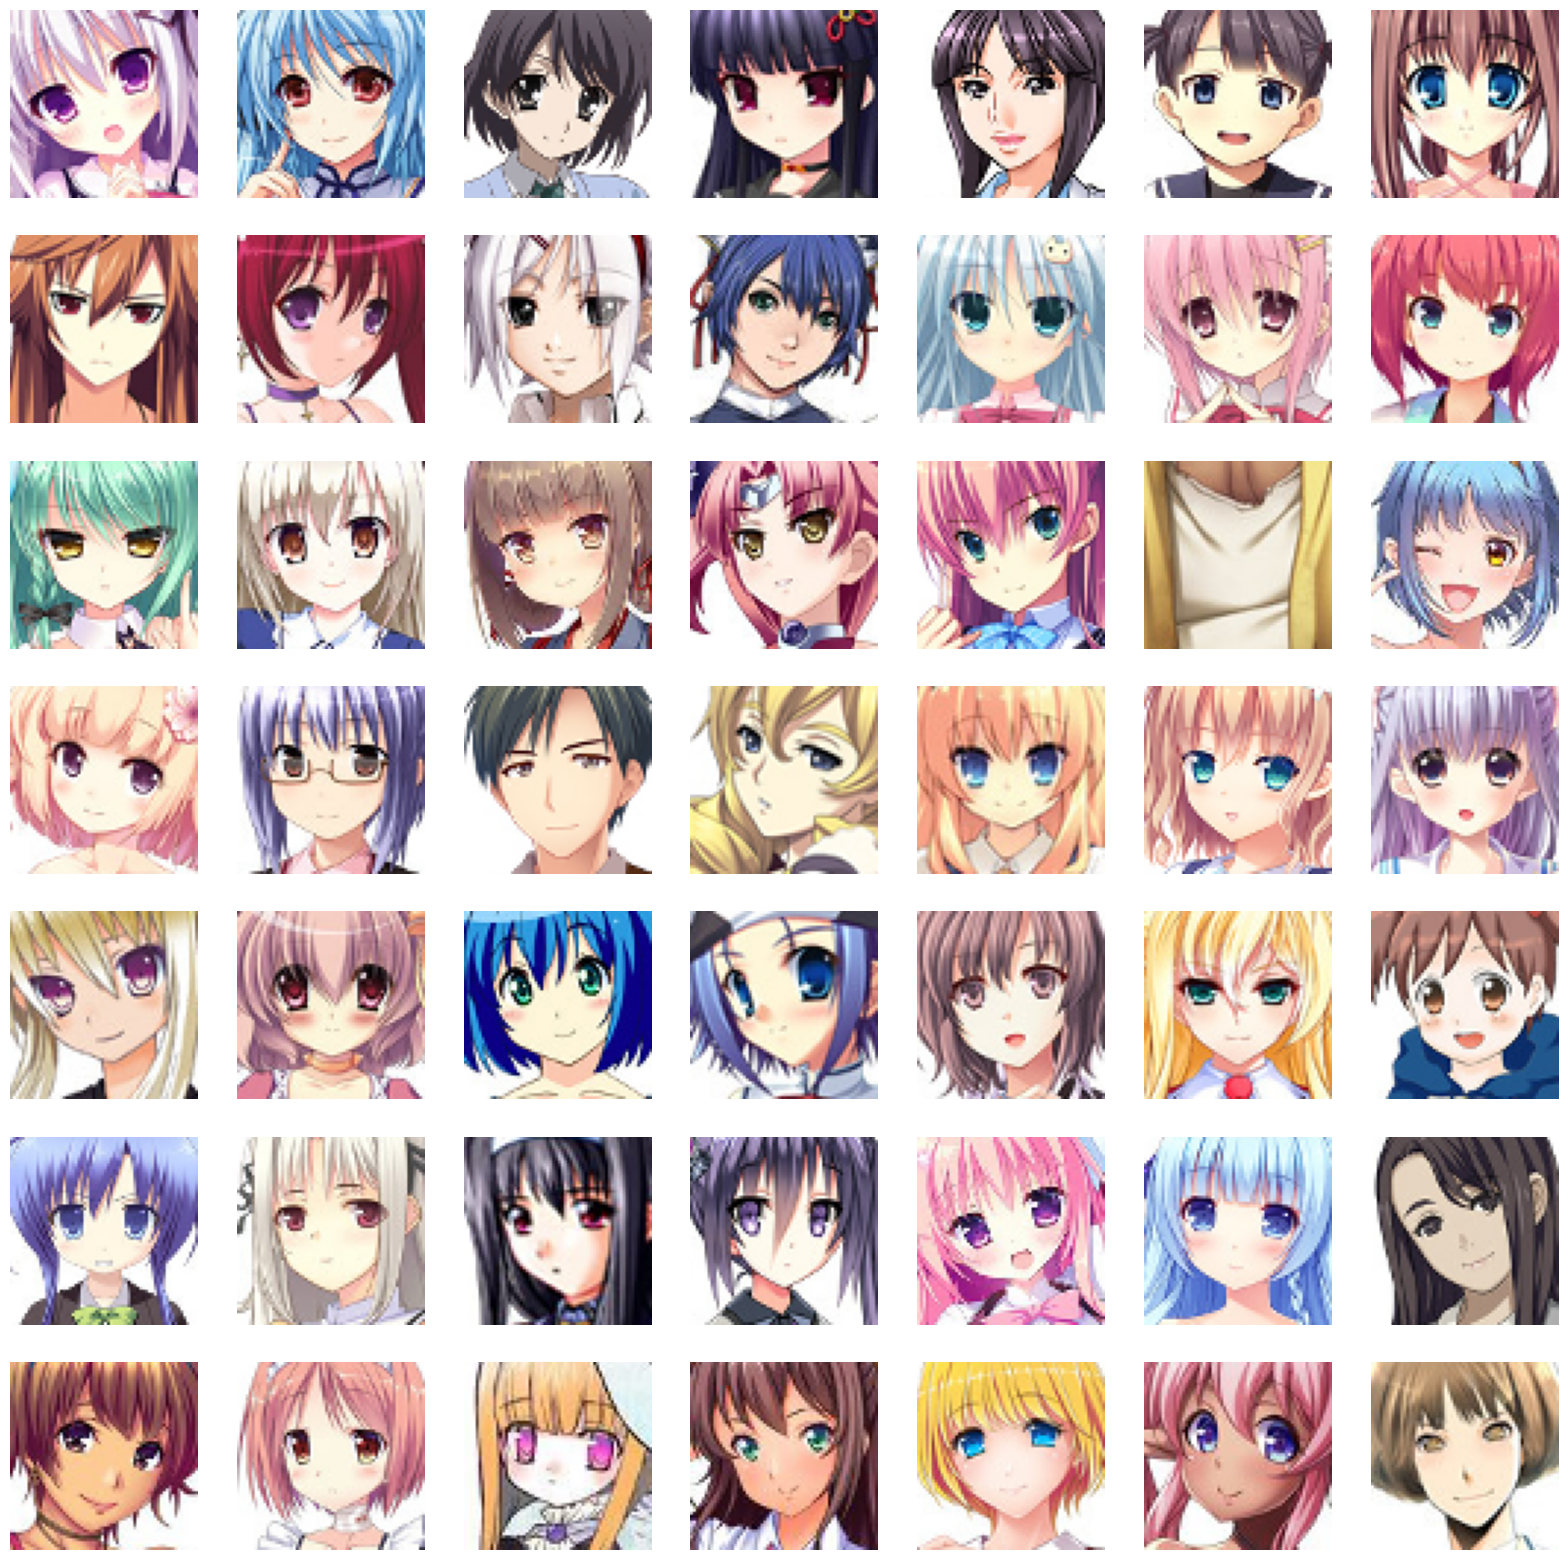

In [ ]:
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    img = load_img(image_path)
    img = np.array(img)

    plt.imshow(img)
    plt.axis('off')
    index = index+1

In [ ]:
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [ ]:
train_images[0].shape

(64, 64, 3)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 64,64,3).astype('float32')

In [ ]:
train_images = (train_images -127.5)/127.5

In [ ]:
train_images[0]

array([[[ 0.84313726,  0.67058825,  0.77254903],
        [ 0.96862745,  0.9529412 ,  0.9607843 ],
        [ 0.96862745,  0.9529412 ,  0.9529412 ],
        ...,
        [ 0.654902  ,  0.41960785,  0.73333335],
        [-0.28627452, -0.5137255 , -0.23921569],
        [-0.6156863 , -0.85882354, -0.58431375]],

       [[ 0.8039216 ,  0.6392157 ,  0.7647059 ],
        [ 0.9529412 ,  0.92941177,  0.9607843 ],
        [ 0.9764706 ,  0.9607843 ,  0.9764706 ],
        ...,
        [ 0.5764706 ,  0.3647059 ,  0.6392157 ],
        [ 0.38039216,  0.12156863,  0.46666667],
        [-0.5529412 , -0.8509804 , -0.5921569 ]],

       [[ 0.79607844,  0.5764706 ,  0.7176471 ],
        [ 0.96862745,  0.9137255 ,  0.94509804],
        [ 0.9607843 ,  0.9529412 ,  0.9607843 ],
        ...,
        [ 0.52156866,  0.30980393,  0.58431375],
        [ 0.64705884,  0.3882353 ,  0.7411765 ],
        [-0.07450981, -0.3647059 , -0.09803922]],

       ...,

       [[ 0.7490196 ,  0.5137255 ,  0.6862745 ],
        [ 0

In [ ]:
from tensorflow.keras.initializers import RandomNormal

LATENT_DIM = 100
WEIGHT_INIT = RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 3

In [ ]:
from tensorflow.keras import layers, Sequential

generator = Sequential(name='generator')

generator.add(layers.Dense(8 * 8 * 512, input_shape=(LATENT_DIM,), kernel_initializer=WEIGHT_INIT))
generator.add(layers.ReLU())

generator.add(layers.Reshape((8, 8, 512)))

generator.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.ReLU())

generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.ReLU())

generator.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.ReLU())

generator.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,065,603 (23.14 MB)

 Trainable params: 6,065,603 (23.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, Sequential

input_shape = (64, 64, 3)
alpha = 0.2

discriminator = Sequential(name='discriminator')

discriminator.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

discriminator.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

discriminator.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,081 (1.55 MB)

 Trainable params: 405,441 (1.55 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
from tensorflow import keras

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

    def on_train_end(self, logs=None):
        self.model.generator.save('/content/drive/My Drive/models/generator.h5')

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001
G_LR = 0.0001
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
N_EPOCHS = 100
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

Epoch 1/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - d_loss: 0.1877 - g_loss: 3.6318
Epoch 2/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - d_loss: 0.0171 - g_loss: 4.9949
Epoch 3/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - d_loss: 0.0520 - g_loss: 6.1637
Epoch 4/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0483 - g_loss: 5.8727
Epoch 5/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0816 - g_loss: 5.2512
Epoch 6/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0709 - g_loss: 5.0605
Epoch 7/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0399 - g_loss: 5.2688
Epoch 8/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0599 - g_loss: 4.9967
Epoch 9/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - d_loss: 0.0986 - g_loss: 4.5222
Epoch 10/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - d_loss: 0.1046 - g_loss: 4.5731
Epoch 11/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - d_loss: 0.1257 - g_loss: 4.4629
Epoch 12/100
674/67

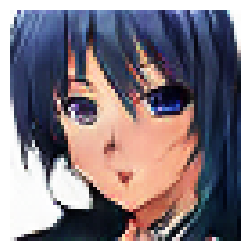

In [ ]:
noise = tf.random.normal([1,100])
fig = plt.figure(figsize=(3,3))
g_img = dcgan.generator(noise)
g_img = (g_img*127.5) + 127.5
g_img = array_to_img(g_img[0])
plt.imshow(g_img)
plt.axis('off')
plt.show()